<a href="https://colab.research.google.com/github/thinh12112001/Ryerson_MRP/blob/master/vgg16_01_04_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install keras-applications


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Preprocess data


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
#from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import PIL

AUTOTUNE = tf.data.experimental.AUTOTUNE
#BATCH_SIZE = 16 * strategy.num_replicas_in_sync
BATCH_SIZE = 16 #40
IMAGE_SIZE = [224, 224]
EPOCHS = 50

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.12.0


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/colab/data_04/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/colab/data_04/train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 5120 files belonging to 2 classes.
Using 4096 files for training.
Found 5120 files belonging to 2 classes.
Using 1024 files for validation.


In [ ]:
class_names = ['alzheimers', 'nonalzheimers']
train_ds.class_names = class_names
val_ds.class_names = class_names

NUM_CLASSES = len(class_names)
print(len(class_names))

2


In [ ]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
NUM_IMAGES = []

for label in class_names:
    dir_name = "/content/drive/MyDrive/colab/data_04/train/" + label[:-2] + 'rs'
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

In [ ]:
NUM_IMAGES

[2560, 2560]

Testing data


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/colab/data_04/validation",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1280 files belonging to 2 classes.


In [ ]:
# def exponential_decay(lr0, s):
#     def exponential_decay_fn(epoch):
#         if lr0 > 0.001:
#             return lr0 * 0.1 ** (epoch / s)
#         return lr0  
#     return exponential_decay_fn


# exponential_decay_fn = exponential_decay(0.01, 20)

# lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model_new.h5",
#                                                     save_best_only=True)

# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
import numpy as np
import warnings

from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras_applications.imagenet_utils import decode_predictions
from keras_applications.imagenet_utils import preprocess_input
from keras_applications.imagenet_utils import _obtain_input_shape
from tensorflow.keras.layers import Input
from tensorflow.keras import Model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# import os
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# TRAINING_DIR = '/content/drive/MyDrive/colab/data_04/train'

# # Split the data into training and validation sets
# train_files, val_files = train_test_split(os.listdir(TRAINING_DIR), test_size=0.2, random_state=42)

# # Define the data augmentation parameters
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode='nearest',
#     validation_split=0.2 # use 20% of the data for validation
# )

# # Create the data generators for training and validation sets
# train_generator = train_datagen.flow_from_directory(
#     TRAINING_DIR,
#     batch_size=16,
#     class_mode='categorical', # or 'binary'
#     target_size=(224, 224),
#     subset='training', # use only the training subset
#     shuffle=True,
#     seed=42
# )
# valid_datagen = ImageDataGenerator(
#     rescale=1./255,
#     validation_split=0.2
# )
# validation_generator = train_datagen.flow_from_directory(
#     TRAINING_DIR,
#     batch_size=16,
#     class_mode='categorical', # or 'binary'
#     target_size=(224, 224),
#     subset='validation', # use only the validation subset
#     shuffle=False,
#     seed=42
# )


In [ ]:
from keras.utils.layer_utils import get_source_inputs
from tensorflow.keras.layers import Input, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.callbacks import ReduceLROnPlateau
wp = '/content/drive/MyDrive/colab/vgg16-kernels-notop-h5/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

#mailchung
#wp = '/content/drive/MyDrive/vgg16-kernel-notop/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
#end
vgg16_base = VGG16(include_top=False, weights=wp,
                   input_tensor=None, input_shape=(224, 224, 3))




output = vgg16_base.get_layer(index = -1).output  
output = Flatten()(output)
output = Dense(1024, activation="relu")(output) # , kernel_regularizer=regularizers.l2(0.01) ==> không tăng val_acc
output = BatchNormalization()(output)
output = Dropout(0.55)(output) #0.2
output = Dense(1024,activation = "relu", kernel_regularizer=regularizers.l2(1))(output) #0.01, kernel_regularizer=regularizers.l2(0.01)
output = BatchNormalization()(output)
output = Dropout(0.55)(output)
output = Dense(2, activation='softmax')(output) #sigmoid if binary



vgg16_model = Model(vgg16_base.input, output)
for layer in vgg16_model.layers[:-7]:
    layer.trainable = False

rop_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=6,
    verbose=1,
    mode='min',
    min_delta=0.0001,
    cooldown=3,
    min_lr=0.0001
)

from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')
#adam
vgg16_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics =['accuracy']) # binary_crossentropy if binary

# with strategy.scope():
#     # METRICS = [tf.keras.metrics.Accuracy(name='acc')]
#     METRICS = [tf.keras.metrics.BinaryAccuracy(name='acc')]
#     model.compile(
#         optimizer='adam',
#         loss=tf.losses.CategoricalCrossentropy(),
#         metrics=METRICS
#     )
history = vgg16_model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[rop_callback,early_stopping, model_checkpoint], #early_stopping
    epochs=EPOCHS
)

Epoch 1/50
256/256 [==============================] - 26s 93ms/step - loss: 48.2252 - accuracy: 0.6401 - val_loss: 2.2049 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 2/50
256/256 [==============================] - 24s 93ms/step - loss: 1.9275 - accuracy: 0.7319 - val_loss: 1.6672 - val_accuracy: 0.7266 - lr: 0.0010
Epoch 3/50
256/256 [==============================] - 23s 90ms/step - loss: 1.5332 - accuracy: 0.8054 - val_loss: 1.6930 - val_accuracy: 0.7051 - lr: 0.0010
Epoch 4/50
256/256 [==============================] - 23s 91ms/step - loss: 1.4229 - accuracy: 0.8379 - val_loss: 1.3635 - val_accuracy: 0.7988 - lr: 0.0010
Epoch 5/50
256/256 [==============================] - 23s 90ms/step - loss: 1.3210 - accuracy: 0.8542 - val_loss: 1.3355 - val_accuracy: 0.7822 - lr: 0.0010
Epoch 6/50
256/256 [==============================] - 24s 93ms/step - loss: 1.2233 - accuracy: 0.8772 - val_loss: 1.3734 - val_accuracy: 0.8027 - lr: 0.0010
Epoch 7/50
256/256 [==============================] - 24s

In [ ]:
_ = vgg16_model.evaluate(test_ds)

80/80 [==============================] - 5s 67ms/step - loss: 0.4593 - accuracy: 0.9055


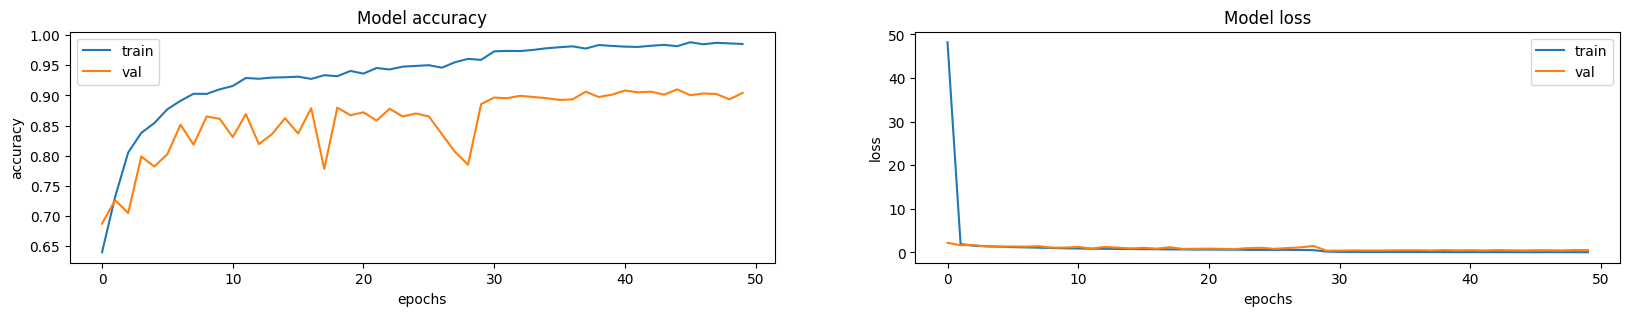

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])